In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import xgboost
import numpy as np
from scipy.sparse import csr_matrix, diags
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
iris = load_iris(as_frame=True)
X, y = load_iris(return_X_y=True)
iris = iris['data']
X_train, X_test, y_train, y_test = train_test_split(X, y)

skrf = RandomForestClassifier(max_depth=3, random_state=0)
skrf.fit(X_train, y_train)
skpreds = skrf.predict(X_test)

# access trees
# trees = skrf.estimators_
leaves = skrf.apply(X_train)

In [4]:
def make_adjacency(leaves):

    n_samples, n_trees = leaves.shape
    
    # give each (tree, leaf) a unique global ID
    unique_leafIDs = []
    offset = 0
    offsets = []
    mappings = []
    for t in range(n_trees):
        col = leaves[:, t]
        # relabel leaves 
        unique, relabeled = np.unique(col, return_inverse=True)
        unique_leafIDs.append(relabeled + offset)
        mapping = {u: i for i, u in enumerate(unique)}
        mappings.append(mapping)
        offsets.append(offset)
        offset += len(unique)
    leafIDs_global = np.column_stack(unique_leafIDs)

    # Build sparse membership matrix M
    row_ind = np.repeat(np.arange(n_samples), n_trees)
    col_ind = leafIDs_global.ravel()
    data = np.ones_like(row_ind, dtype=np.float32)

    M = csr_matrix((data, (row_ind, col_ind)), shape=(n_samples, offset))

    # leaf sizes and weights
    leaf_sizes = np.array(M.sum(axis=0)).ravel()
    leaf_weights = 1.0 / np.maximum(leaf_sizes, 1)  # avoid div by zero

    M_norm = M @ diags(leaf_weights)
    A = (M_norm @ M.T) / n_trees
    
    metadata = {
        "offsets": offsets,
        "leaf_weights": leaf_weights,
        "M_norm": M_norm,
        "total_leaves": offset,
        "mappings": mappings
    }
    return A.toarray(), metadata

In [5]:
A, metadata = make_adjacency(leaves)
new_leaves = skrf.apply(X_test)

In [6]:
def new_adjacency(new_leaves, metadata):
    offsets = metadata["offsets"]
    leaf_weights = metadata["leaf_weights"]
    M_norm_train = metadata["M_norm"]
    n_new, n_trees = new_leaves.shape
    total_leaves = metadata["total_leaves"] 
    mappings = metadata["mappings"]

    new_leafIDs = []
    for t in range(n_trees):
        mapping = mappings[t]
        relabeled = np.array([mapping[lid] for lid in new_leaves[:, t]])
        new_leafIDs.append(relabeled + offsets[t])
    leafIDs_global = np.column_stack(new_leafIDs)
    row_ind = np.repeat(np.arange(n_new), n_trees)
    col_ind = leafIDs_global.ravel()

    data = np.ones_like(row_ind, dtype=np.float32)

    M_new = csr_matrix((data, (row_ind, col_ind)), shape=(n_new, total_leaves))
    M_norm_new = M_new @ diags(leaf_weights)
    A_new = (M_norm_new @ M_norm_train.T) / n_trees
    return A_new

In [7]:
A_new = new_adjacency(new_leaves, metadata)
D = 1-A

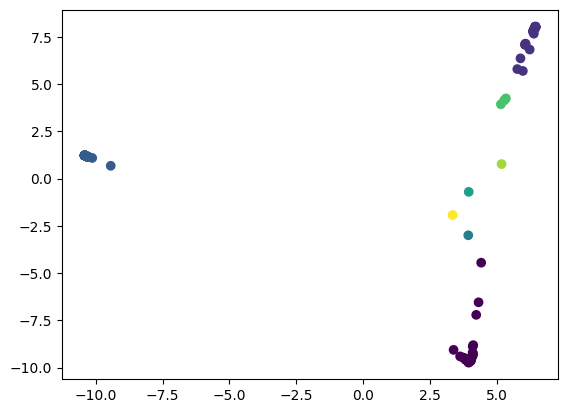

In [8]:
clustering = AgglomerativeClustering(n_clusters = None, distance_threshold = 0.1, linkage = 'single').fit(D)
clustering.labels_
# little sanity check - pca kernel data and plot to see if the clusters make sense
sc = StandardScaler()
pca_data = sc.fit_transform(D)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(pca_data).T
plt.scatter(pca_data[0, ], pca_data[1, ], c=clustering.labels_)
plt.show() 

Looks pretty okay? 

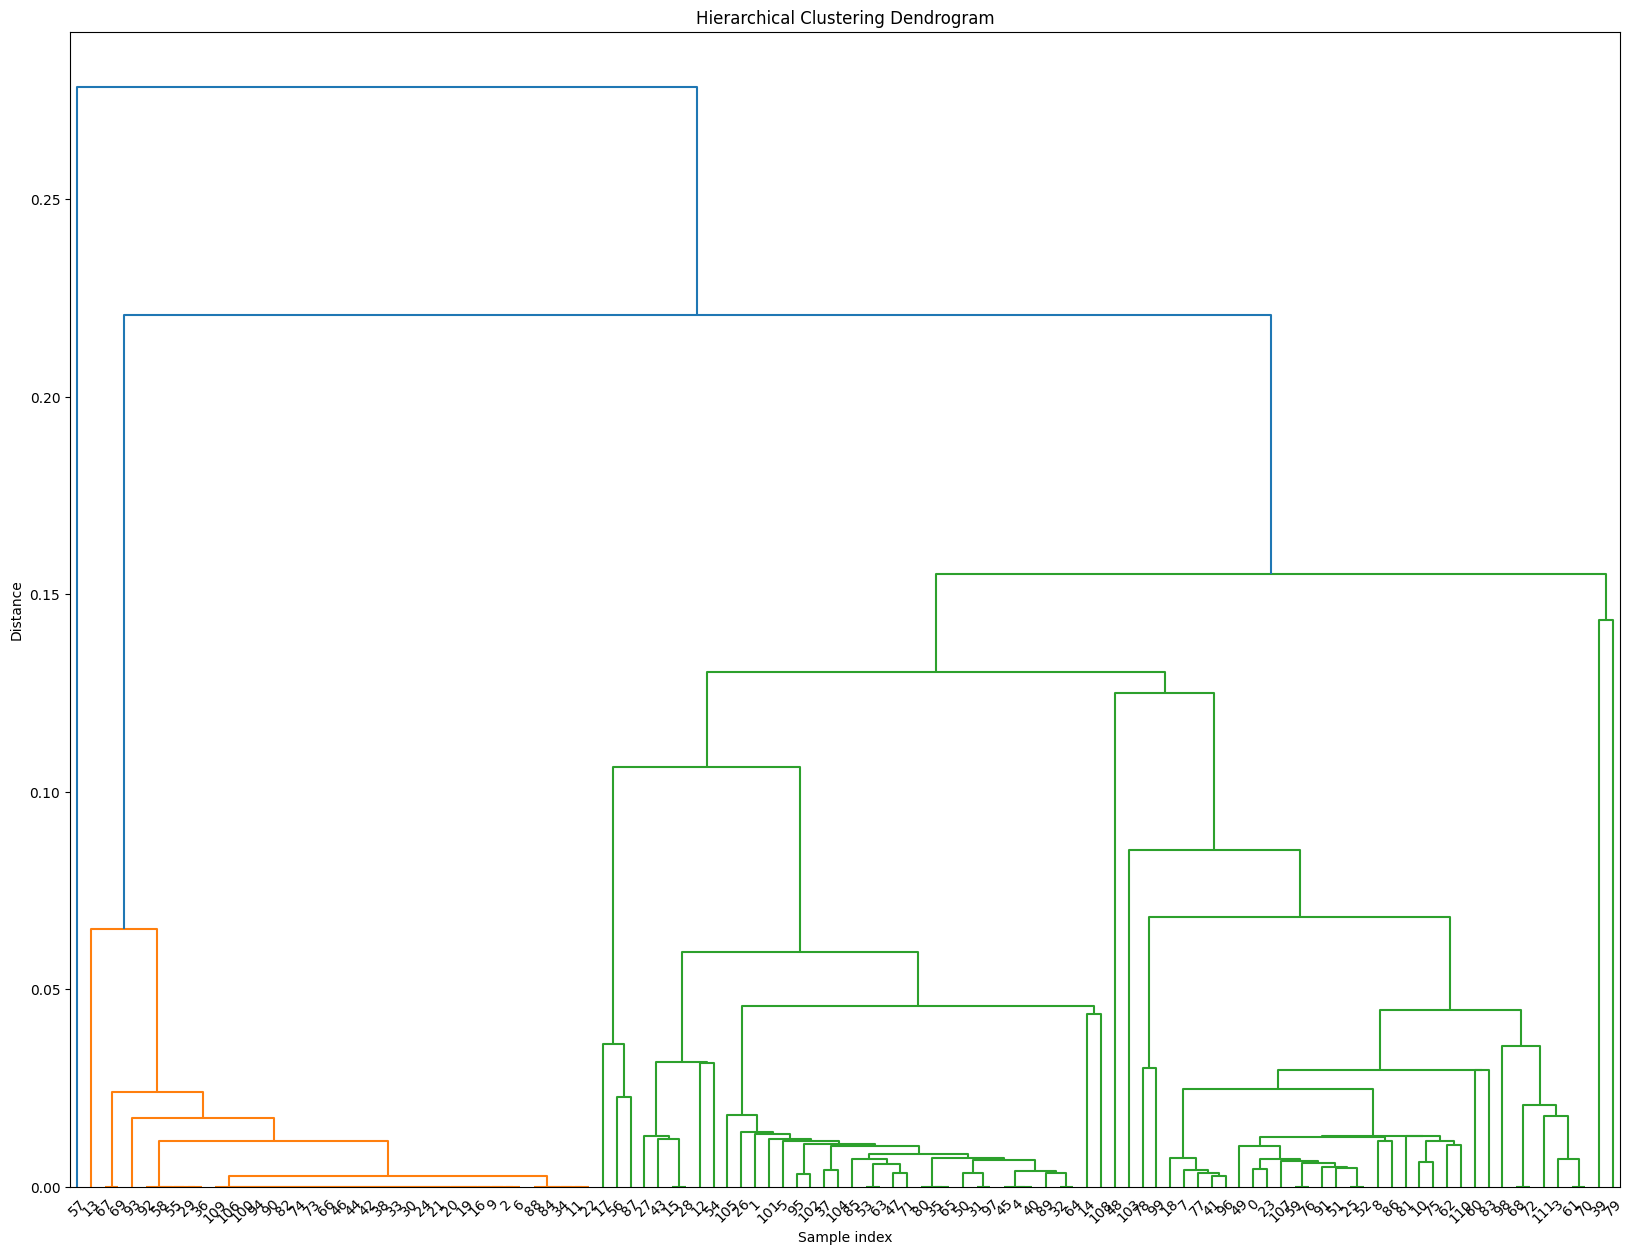

In [9]:
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree

Z = linkage(D, method = 'single')
plt.figure(figsize=(20, 15))
dendrogram(Z, truncate_mode=None, leaf_rotation=45, leaf_font_size=10.)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

In [11]:
rootnode, nodelist = to_tree(Z, rd=True)

In [12]:
len(nodelist)

223

total node list = n + (n-1)

In [13]:
len(X_train)

112

In [ ]:
leftnode = rootnode.left
leftnode.right

In [26]:
rootnode.id


222

In [28]:
rootnode.left.id

57

In [30]:
def extract_nodes(node):
    if node.is_leaf():
        return [{"id": node.id, "left": None, "right": None, "dist": 0, "count": 1}]
    else:
        left = extract_nodes(node.left)
        right = extract_nodes(node.right)
        current = [{"id": node.id, "left": node.left.id, "right": node.right.id,
                    "dist": node.dist, "count": node.count}]
        return left + right + current

# Get a flat list of all nodes
node_list = extract_nodes(rootnode)

In [32]:
node_list

[{'id': 57, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 13, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 67, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 69, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 154, 'left': 67, 'right': 69, 'dist': np.float64(0.0), 'count': 2},
 {'id': 93, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 92, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 58, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 55, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 29, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 36, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 124, 'left': 29, 'right': 36, 'dist': np.float64(0.0), 'count': 2},
 {'id': 125, 'left': 55, 'right': 124, 'dist': np.float64(0.0), 'count': 3},
 {'id': 126, 'left': 58, 'right': 125, 'dist': np.float64(0.0), 'count': 4},
 {'id': 127, 'left': 92, 'right': 126, 'dist

In [14]:
trees = skrf.estimators_
new_leaves

array([[1, 1, 2, ..., 1, 1, 1],
       [8, 8, 8, ..., 6, 8, 8],
       [8, 5, 7, ..., 5, 4, 4],
       ...,
       [1, 1, 2, ..., 1, 1, 1],
       [8, 8, 7, ..., 6, 5, 8],
       [4, 4, 7, ..., 4, 4, 5]], shape=(38, 100))

In [34]:
Z.shape

(111, 4)

In [16]:
tree_0 = trees[0]
print(tree_0.tree_.children_left)
print(tree_0.tree_.children_right)

[ 1 -1  3  4 -1 -1  7 -1 -1]
[ 2 -1  6  5 -1 -1  8 -1 -1]


In [38]:
Z[0]

array([59., 76.,  0.,  2.])